# t-SNE Feature Visualization  

이전 실습에서는 MNIST 데이터셋을 통한 image classification 및 autoencoder image reconstruction task를 실습하였습니다.  

각 task마다 이미지 데이터를 encode한 feature가 도출되었습니다. 이번 실습에서는 t-SNE를 통해 도출된 feature를 시각화해 보고, task별 또는 model별  feature 분포의 특징을 살펴보겠습니다.  


(참고)   
https://medium.com/@vegi/visualizing-higher-dimensional-data-using-t-sne-on-tensorboard-7dbf22682cf2  
https://comafire.github.io/posts/2017-mnist-dataset-tsne/  
https://www.kaggle.com/giuseppemerendino/deep-mushroom-keras-t-sne  
https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_tsne.html

In [1]:
from collections import Counter
import numpy as np
import json

import keras
from keras import models
from keras.datasets import mnist
from keras.optimizers import RMSprop
from keras.models import model_from_json
from sklearn import preprocessing

import sklearn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# to reproduce same training result
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

### t-SNE Visualization method

In [3]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

def draw_scatter(tsne_results, n_class, targets):
    plt.figure(figsize=(10, 10))
    colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
    for i in range(n_class):
        plt.scatter(tsne_results[targets == i, 0], tsne_results[targets == i, 1], c=colors[i], label=i)
    plt.legend()
    plt.show()

# t-SNE visualization of MNIST Original Data 

이번에는 28*28=784 차원으로 이루어진 MNIST 데이터 자체를 2차원 t-SNE에 투영해 보겠습니다.

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
x_train = x_train.astype('float32') / 255.
x_train.shape

(60000, 784)

6만개의 데이터를 전부 처리하기에는 계산 비용이 크므로, 1천개만 샘플링해서 시각화해 보겠습니다.

In [6]:
ridx = np.random.randint(x_train.shape[0], size=1000)
np_x_train = x_train[ridx, :]
np_y_train = y_train[ridx]
print(ridx[:20])
print(np_y_train[:20])
counter_train = Counter(np_y_train)
print(counter_train)
print(np_x_train.shape)
print(np_y_train.shape)

[33003 12172  5192 32511 50057 43723  7813 52047 21440 32912 20609 49100
  7751 43757 31228 36230 32025 58546 54548 21758]
[0 9 0 5 0 7 0 0 5 6 0 5 4 4 6 7 3 0 9 7]
Counter({1: 117, 4: 106, 0: 105, 5: 103, 9: 100, 6: 100, 8: 96, 7: 94, 3: 92, 2: 87})
(1000, 784)
(1000,)


In [7]:
tsne_x_train = TSNE(n_iter=10000).fit_transform(np_x_train)

In [8]:
tsne_x_train.shape

(1000, 2)

In [9]:
tsne_x_train[np_y_train==0, 0]

array([-39.33565 , -44.337498, -45.68541 , -42.18276 , -53.587242,
       -44.462563, -38.5439  , -46.666077, -38.155727, -37.004932,
       -51.983482,  18.080765, -41.2353  , -49.934364, -46.547684,
       -39.221848, -43.66909 , -32.37688 , -49.455875, -45.83171 ,
        24.944977, -53.958824, -50.59654 , -49.966465, -53.314503,
       -53.314503, -45.982597, -35.555763, -39.41876 , -37.240147,
        19.027504,  19.91829 , -47.728416, -40.96296 , -40.79029 ,
       -52.568245, -36.76053 , -41.384087,  19.074903, -40.11495 ,
       -44.30641 , -43.565903, -44.72141 , -43.2002  ,  46.21736 ,
       -50.40437 , -49.201035, -48.109055, -43.510647, -51.09636 ,
       -38.448315, -47.04728 , -48.832973,  21.02447 , -52.084785,
       -47.459064, -41.961136, -50.26328 , -43.9454  , -46.49059 ,
       -45.282322, -52.661953, -40.897102, -36.646824, -47.73627 ,
       -51.429337, -38.223278, -43.752926, -45.047894, -43.878746,
       -53.30181 , -39.738125, -45.035442,  45.642963, -44.507

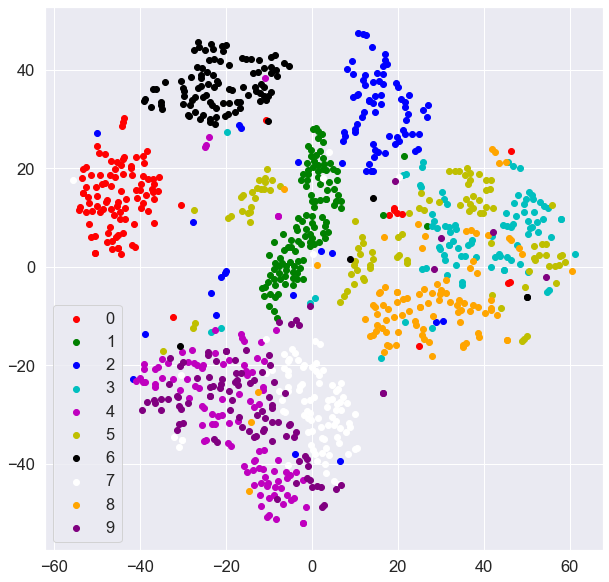

In [10]:
n_class = 10
draw_scatter(tsne_x_train, n_class, np_y_train)

# t-SNE visualization of MNIST Classification Feature 

이번에는 MNIST image classification task의 feature를 2차원 t-SNE에 투영해 보겠습니다.

In [11]:
keras.backend.clear_session()

In [12]:
with open('checkpoints/cnn_model.json','r') as f:
    model_json = json.load(f)
#     print(model_json)

model = model_from_json(str(model_json))
model.load_weights('checkpoints/cnn_model.h5')
model.summary()  # 기억을 되살리기 위해서 모델 구조를 출력합니다
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)    

In [13]:
# layer의 output으로만 이루어진 list를 만들어 봅시다.
layer_outputs = [layer.output for layer in model.layers]
layer_outputs

[<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 28, 28, 32) dtype=float32>,
 <tf.Tensor 'conv2d_2/Relu:0' shape=(?, 28, 28, 32) dtype=float32>,
 <tf.Tensor 'max_pooling2d_1/MaxPool:0' shape=(?, 14, 14, 32) dtype=float32>,
 <tf.Tensor 'dropout_1/cond/Merge:0' shape=(?, 14, 14, 32) dtype=float32>,
 <tf.Tensor 'conv2d_3/Relu:0' shape=(?, 14, 14, 64) dtype=float32>,
 <tf.Tensor 'conv2d_4/Relu:0' shape=(?, 14, 14, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_2/MaxPool:0' shape=(?, 7, 7, 64) dtype=float32>,
 <tf.Tensor 'dropout_2/cond/Merge:0' shape=(?, 7, 7, 64) dtype=float32>,
 <tf.Tensor 'flatten_1/Reshape:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'dense_1/Relu:0' shape=(?, 256) dtype=float32>,
 <tf.Tensor 'dropout_3/cond/Merge:0' shape=(?, 256) dtype=float32>,
 <tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'activation_1/Softmax:0' shape=(?, 10) dtype=float32>]

In [14]:
layer_outputs[10]

<tf.Tensor 'dropout_3/cond/Merge:0' shape=(?, 256) dtype=float32>

In [15]:
# 입력에 대해 CNN의 11번째 output(shape=(?, 256)_을 반환하는 모델을 만듭니다:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [16]:
# 1000개의 샘플링한 입력데이터 reshape
x_test_input = np.reshape(np_x_train, (-1, 28, 28, 1))
x_test_input.shape

(1000, 28, 28, 1)

In [20]:
# classification model의 logit 직전 feature를 출력합니다.
activations  = activation_model.predict(x_test_input)
activations[10].shape    # 11번째 레이어가 우리가 관심있는 feature output

(1000, 256)

In [21]:
tsne_x_train = TSNE(n_iter=10000).fit_transform(activations[10])

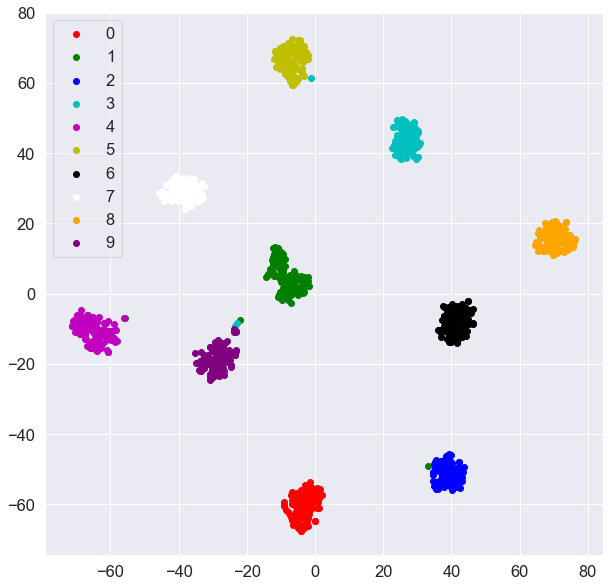

In [22]:
n_class = 10
draw_scatter(tsne_x_train, n_class, np_y_train)

# t-SNE visualization of MNIST ConvAutoEncoder Feature 

이번에는 MNIST Convolutional AutoEncoder의 feature를 2차원 t-SNE에 투영해 보겠습니다.

In [23]:
keras.backend.clear_session()

In [24]:
with open('checkpoints/conv_ae_encoder.json','r') as f:
    model_json = json.load(f)

model = model_from_json(str(model_json))
model.load_weights('checkpoints/conv_ae_encoder.h5')
model.summary()  # 기억을 되살리기 위해서 모델 구조를 출력합니다

model.compile(optimizer='adadelta', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 4)           0         
Total para

In [25]:
# classification model의 logit 직전 feature를 출력합니다.
activations  = model.predict(x_test_input)
activations.shape    # 11번째 레이어가 우리가 관심있는 feature output

(1000, 4, 4, 4)

In [26]:
activations = activations.reshape(activations.shape[0], np.prod(activations.shape[1:]))
activations.shape

(1000, 64)

In [27]:
tsne_x_train = TSNE(n_iter=10000).fit_transform(activations)

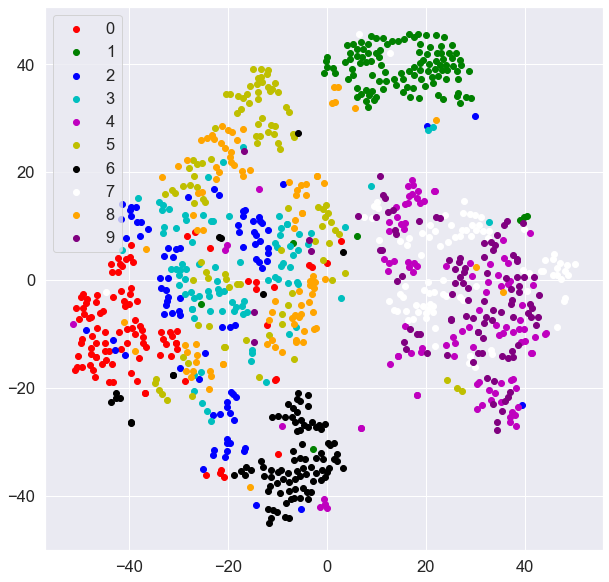

In [28]:
n_class = 10
draw_scatter(tsne_x_train, n_class, np_y_train)